Creating decision tree with c4.5 algorithm

Based on [script](https://github.com/barisesmer/C4.5/blob/master/c45/c45.py)

**Data format:**

There are two files, one that describes the classes and attributes and the other that consists of the data. The file for attributes and classes contains all the classes name in first line and records line by line the attributes and their possible values if the attribute is discrete, and if attributes is continuous the possible values should be "continuous".

*The file for attributes and classes (i.e. feature_path):*

|Iris-setosa, Iris-versicolor, Iris-virginica|
|--------------------------------------------|
|sepal length : continuous|
|sepal width : continuous|
|petal length : continuous|
|petal width : continuous|


In [5]:
import math

class C45:
    def __init__(self,data_path,feature_path):
        self.data_path = data_path
        self.feature_path = feature_path
        self.data = []
        self.classes = []
        self.numAttributes = 0
        self.attrValues = {}
        self.attributes = []
        self.tree = None
    
    def fetchData(self):
        with open(self.feature_path,'r') as file:
            # add classes
            classes = file.readline()
            self.classes = [x.strip() for x in classes.split(',')]
            # add atributes
            for line in file:
                [attribute,values] = [x.strip() for x in line.split(':')]
                values = [x.strip() for x in values.split(',')]
                self.attrValues[attribute] = values
        self.numAttributes = len(self.attrValues.keys())
        self.attributes = list(self.attrValues.keys())
        with open(self.data_path,'r') as file:
            for line in file:
                row = [x.strip() for x in line.split(',')]
                if row != [] or row != ['']:
                    self.data.append(row)
                    
    def preprocessData(self):
        for index,row in enumerate(self.data):
            for attr_index in range(self.numAttributes):
                if(not self.isAttrDiscrete(self.attributes[attr_index])):
                    self.data[index][attr_index] = float(self.data[index][attr_index])
                    
    def printTree(self):
        self.printNode(self.tree)
        
    def printNode(self,node,indent=''):
        if not node.isLeaf:
            if node.threshold is None:
                # discrete
                for index,child in enumerate(node.children):
                    if child.isLeaf:
                        print(indent+node.label+'='+attributes[index]+':'+child.label)
                    else:
                        print(indent+node.label+'='+attributes[index]+':')
                        self.printNode(child,indent+'        ')
            else:
                # continous
                leftChild = node.children[0]
                rightChild = node.children[1]
                if leftChild.isLeaf:
                    print(indent+node.label+'<='+str(node.threshold)+':'+leftChild.label)
                else:
                    print(indent+node.label+'<='+str(node.threshold)+':')
                    self.printNode(leftChild,indent+'    ')
                
                if rightChild.isLeaf:
                    print(indent+node.label+'>'+str(node.threshold)+':'+rightChild.label)
                else:
                    print(indent+node.label+'>'+str(node.threshold)+':')
                    self.printNode(rightChild,indent+'  ')
    
    def generateTree(self):
        self.tree = self.recursiveGenerateTree(self.data,self.attributes)
        
    def recursiveGenerateTree(self,curData,curAttributes):
        allSame = self.allSameClass(curData)
        
        if len(curData) == 0:
            return Node(True,'Fail',None)
        elif allSame is not False:
            return Node(True,allSame,None)
        elif len(curAttributes) == 0:
            majClass = self.getMajClass(curData)
            return Node(True,majClass,None)
        else:
            (best,best_threshold,splitted) = self.splitAttribute(curData,curAttributes)
            remainingAttributes = curAttributes[:]
            remainingAttributes.remove(best)
            node = Node(False,best,best_threshold)
            node.children = [self.recursiveGenerateTree(subset,remainingAttributes) for subset in splitted]
            return node
    def getMajClass(self,curData):
        freq = [0]*len(self.classes)
        for row in curData:
            index = self.classes.index(row[-1])
            freq[index]+=1
        maxInd = freq.index(max(freq))
        return self.classes[maxInd]
    
    def allSameClass(self,data):
        for row in data:
            if row[-1] != data[0][-1]:
                return False
        return data[0][-1]
    
    def isAttrDiscrete(self,attribute):
        if attribute not in self.attributes:
            raise ValueError('Attribute not listed')
        elif len(self.attrValues[attribute]) == 1 and self.attrValues[attribute][0]=='continuous':
            return False
        else:
            return True
        
    def splitAttribute(self,curData,curAttributes):
        splitted = []
        maxEnt = -1*float('inf')
        best_attribute = -1
        # None for discrete attributes,threshold value for continuous attributes
        best_threshold = None
        for attribute in curAttributes:
            indexOfAttribute = self.attributes.index(attribute)
            if self.isAttrDiscrete(attribute):
                #split curData into n-subsets, where n is the number of different
                #values of attribute i. Choose the attribute with the max info gain.
                valuesForAttribute = self.attrValues[attribute]
                subsets = [[] for a in valuesForAttribute]
                for row in curData:
                    for index in range(len(valuesForAttribute)):
                        if row[i]==valuesForAttribute[index]:
                            subsets[index].append(row)
                            break
                            
                e = gain(curData,subsets)
                if e > maxEnt:
                    maxEnt = e
                    splitted = subsets
                    best_attribute = attribute
                    best_threshold = None
            else:
                # sort data according to the column and try all possible
                # adjacent pairs. Choose the one that yields maximum gain.
                curData.sort(key = lambda x:x[indexOfAttribute])
                for j in range(0,len(curData)-1):
                    if curData[j][indexOfAttribute]!=curData[j+1][indexOfAttribute]:
                        threshold = (curData[j][indexOfAttribute]+curData[j+1][indexOfAttribute])/2
                        less = []
                        greater = []
                        for row in curData:
                            if(row[indexOfAttribute]>threshold):
                                greater.append(row)
                            else:
                                less.append(row)
                        e = self.gain(curData,[less,greater])
                        if e>=maxEnt:
                            splitted = [less,greater]
                            maxEnt = e
                            best_attribute = attribute
                            best_threshold = threshold
        return (best_attribute,best_threshold,splitted)  
    
    def gain(self,unionSet,subsets):
        S = len(unionSet)
        impurityBeforeSplit = self.entropy(unionSet)
        weights = [len(subset)/S for subset in subsets]
        impurityAfterSplit = 0
        for i in range(len(subsets)):
            impurityAfterSplit += weights[i]*self.entropy(subsets[i])
        totalGain = impurityBeforeSplit - impurityAfterSplit
        return totalGain
    
    def entropy(self,dataSet):
        S = len(dataSet)
        if S==0:
            return 0
        num_classes = [0 for i in self.classes]
        for row in dataSet:
            classIndex = list(self.classes).index(row[-1])
            num_classes[classIndex]+=1
        num_classes = [x/S for x in num_classes]
        ent = 0
        for num in num_classes:
            ent+=num*self.log(num)
        return ent*-1
    
    def log(self,x):
        if x == 0:
            return 0
        else:
            return math.log(x,2)
        
class Node:
    def __init__(self,isLeaf,label,threshold):
        self.label = label
        self.threshold = threshold
        self.isLeaf = isLeaf
        self.children = []

In [6]:
C45 = C45('iris/iris.data','iris/iris.names')
C45.fetchData()
C45.preprocessData()
C45.generateTree()
C45.printTree()

petal width<=0.8:Iris-setosa
petal width>0.8:
  petal length<=4.75:
      sepal length<=4.95:
          sepal width<=2.45:Iris-versicolor
          sepal width>2.45:Iris-virginica
      sepal length>4.95:Iris-versicolor
  petal length>4.75:
    sepal length<=7.0:
        sepal width<=3.25:Iris-virginica
        sepal width>3.25:Iris-virginica
    sepal length>7.0:Iris-virginica


**Implementation by sklearn**

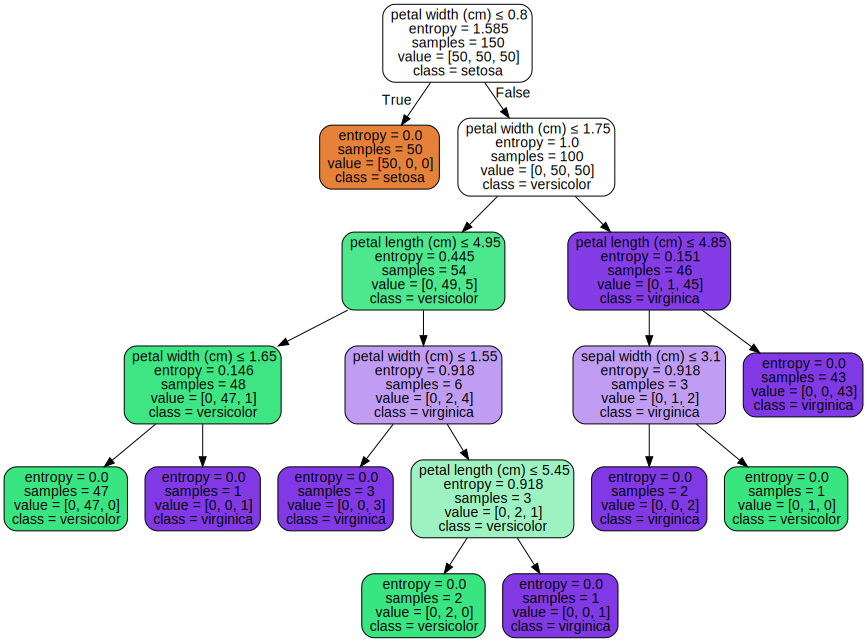

In [22]:
from sklearn.datasets import load_iris
import graphviz
from sklearn import tree

iris = load_iris()
X =iris.data
y = iris.target
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X,y)

dot_data = tree.export_graphviz(clf,out_file=None,
                               feature_names=iris.feature_names,
                               class_names=iris.target_names,
                               filled=True,
                               rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph